# Example: Arbor plus .swc morphology file

Example utilizing the **`LFPykit`** module for predictions of extracellular potentials using 
the line source approximation implementation in class `LineSourcePotential` with a passive neuron model set up in Arbor (https://arbor.readthedocs.io, https://github.com/arbor-sim/arbor). 

The neuron receives sinusoid synaptic current input in one arbitrary chosen control volume (CV). 
Its morphology is defined in the file `single_cell.swc`

In [1]:
%matplotlib inline

In [2]:
## Arbor may be installed using pip. Uncomment and run the following to install Arbor. 
## Then restart the kernel.
# !pip install scikit-build
# !pip install git+https://github.com/arbor-sim/arbor.git@v0.6

In [3]:
## if running on mybinder or similar, uncomment and run the following to install LFPykit. 
## Then restart the kernel.
# !pip install ..

## Define cell model

In [4]:
%load_ext autoreload
%autoreload 2
# import modules
import numpy as np
import arbor
import lfpykit
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.collections import PolyCollection

In [5]:
class Recipe(arbor.recipe):
    def __init__(self, cell):
        super().__init__()

        self.the_cell = cell

        self.vprobe_id = (0, 0)
        self.iprobe_id = (0, 1)
        self.cprobe_id = (0, 2)

        self.the_props = arbor.neuron_cable_properties()

    def num_cells(self):
        return 1

    def num_sources(self, gid):
        return 0

    def cell_kind(self, gid):
        return arbor.cell_kind.cable

    def cell_description(self, gid):
        return self.the_cell

    def global_properties(self, kind):
        return self.the_props

    def probes(self, gid):
        return [
            arbor.cable_probe_membrane_voltage_cell(),
            arbor.cable_probe_total_current_cell(),
            arbor.cable_probe_stimulus_current_cell()
        ]

In [6]:
def make_cable_cell(morphology, clamp_location):
    # number of CVs per branch
    cvs_per_branch = 3

    # Label dictionary
    defs = {}
    labels = arbor.label_dict(defs)

    # decor
    decor = arbor.decor()

    # set initial voltage, temperature, axial resistivity, membrane capacitance
    decor.set_property(
        Vm=-65,  # Initial membrane voltage (mV)
        tempK=300,  # Temperature (Kelvin)
        rL=10000,  # Axial resistivity (Ω cm)
        cm=0.01,  # Membrane capacitance (F/m**2)
    )

    # set passive mechanism all over
    # passive mech w. leak reversal potential (mV)
    pas = arbor.mechanism('pas/e=-65')
    pas.set('g', 0.0001)  # leak conductivity (S/cm2)
    decor.paint('(all)', arbor.density(pas))

    # set number of CVs per branch
    policy = arbor.cv_policy_fixed_per_branch(cvs_per_branch)
    decor.discretization(policy)

    # place sinusoid input current
    iclamp = arbor.iclamp(5,  # stimulation onset (ms)
                          1E8,  # stimulation duration (ms)
                          -0.001,  # stimulation amplitude (nA)
                          frequency=0.1,  # stimulation frequency (kHz)
                          phase=0)  # stimulation phase)
    decor.place(str(clamp_location), iclamp, '"iclamp"')

    # create ``arbor.place_pwlin`` object
    p = arbor.place_pwlin(morphology)

    # create cell and set properties
    cell = arbor.cable_cell(morphology, labels, decor)

    return p, cell

In [7]:
# define morphology (needed for ``arbor.place_pwlin`` and ``arbor.cable_cell`` below)
morphology = arbor.load_swc_arbor('single_cell.swc')

# define a location on morphology for current clamp
clamp_location = arbor.location(4, 1/6)

# get place_pwlin and cable_cell objects
p, cell = make_cable_cell(morphology, clamp_location)

# instantiate recipe with cell
recipe = Recipe(cell)

# instantiate simulation
context = arbor.context()
domains = arbor.partition_load_balance(recipe, context)
sim = arbor.simulation(recipe, domains, context)

# set up sampling on probes with sampling every 1 ms
schedule = arbor.regular_schedule(1.)
v_handle = sim.sample(recipe.vprobe_id, schedule, arbor.sampling_policy.exact)
i_handle = sim.sample(recipe.iprobe_id, schedule, arbor.sampling_policy.exact)
c_handle = sim.sample(recipe.cprobe_id, schedule, arbor.sampling_policy.exact)

# run simulation for 500 ms of simulated activity and collect results.
sim.run(tfinal=500)

# extract time, V_m, I_m and I_c for each CV
V_m_samples, V_m_meta = sim.samples(v_handle)[0]
I_m_samples, I_m_meta = sim.samples(i_handle)[0]
I_c_samples, I_c_meta = sim.samples(c_handle)[0]

# drop recorded V_m values and corresponding metadata of
# zero-sized CVs (branch-point potentials).
# Here this is done as the V_m values are only used for visualization purposes
inds = np.array([m.dist != m.prox for m in V_m_meta])
V_m_samples = V_m_samples[:, np.r_[True, inds]]
V_m_meta = np.array(V_m_meta)[inds].tolist()

# assert that the remaining cables comprising the metadata for each probe
# are identical, as well as the reported sample times.
assert V_m_meta == I_m_meta
assert (V_m_samples[:, 0] == I_m_samples[:, 0]).all()

# prep recorded data for plotting and computation of extracellular potentials
time = V_m_samples[:, 0]
V_m = V_m_samples[:, 1:]

# Add stimulation current to transmembrane current to mimic sinusoid synapse
# current embedded in the membrane.
I_m = I_c_samples[:, 1:] + I_m_samples[:, 1:]  # (nA)

## Compute extracellular potentials
First we define a couple of classes to interface the LFPykit library (https://LFPykit.readthedocs.io, https://github.com/LFPy/LFPykit):

In [8]:
class ArborCellGeometry(lfpykit.CellGeometry):
    '''
    Class inherited from  ``lfpykit.CellGeometry`` for easier forward-model
    predictions in Arbor that keeps track of arbor.segment information
    for each CV.

    Parameters
    ----------
    p: ``arbor.place_pwlin`` object
        3-d locations and cables in a morphology (cf. ``arbor.place_pwlin``)
    cables: ``list``
        ``list`` of corresponding ``arbor.cable`` objects where transmembrane
        currents are recorded (cf. ``arbor.cable_probe_total_current_cell``)

    See also
    --------
    lfpykit.CellGeometry
    '''

    def __init__(self, p, cables):
        x, y, z, d = [np.array([], dtype=float).reshape((0, 2))] * 4
        c_ind = np.array([], dtype=int)  # tracks which CV owns segment
        for i, m in enumerate(cables):
            segs = p.segments([m])
            for j, seg in enumerate(segs):
                x = np.row_stack([x, [seg.prox.x, seg.dist.x]])
                y = np.row_stack([y, [seg.prox.y, seg.dist.y]])
                z = np.row_stack([z, [seg.prox.z, seg.dist.z]])
                d = np.row_stack(
                    [d, [seg.prox.radius * 2, seg.dist.radius * 2]])
                c_ind = np.r_[c_ind, i]

        super().__init__(x=x, y=y, z=z, d=d)
        self._c_ind = c_ind

In [9]:
class ArborLineSourcePotential(lfpykit.LineSourcePotential):
    '''subclass of ``lfpykit.LineSourcePotential`` modified for
    instances of ``ArborCellGeometry``.
    Each CV may consist of several segments , and this implementation
    accounts for their contributions normalized by surface area, that is,
    we assume constant transmembrane current density per area across each CV
    and constant current source density per unit length per segment
    (inherent in the line-source approximation).

    Parameters
    ----------
    cell: object
        ``ArborCellGeometry`` instance or similar.
    x: ndarray of floats
        x-position of measurement sites (µm)
    y: ndarray of floats
        y-position of measurement sites (µm)
    z: ndarray of floats
        z-position of measurement sites (µm)
    sigma: float > 0
        scalar extracellular conductivity (S/m)

    See also
    --------
    lfpykit.LineSourcePotential
    '''

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._get_transformation_matrix = super().get_transformation_matrix

    def get_transformation_matrix(self):
        '''Get linear response matrix

        Returns
        -------
        response_matrix: ndarray
            shape (n_coords, n_cs) ndarray
        '''
        M_tmp = self._get_transformation_matrix()
        n_cs = np.unique(self.cell._c_ind).size
        M = np.zeros((self.x.size, n_cs))
        for i in range(n_cs):
            inds = self.cell._c_ind == i
            M[:, i] = M_tmp[:, inds] @ (self.cell.area[inds] /
                                        self.cell.area[inds].sum())

        return M

In [10]:
# create ``ArborCellGeometry`` instance
cell_geometry = ArborCellGeometry(p, I_m_meta)

# define locations where extracellular potential is predicted in vicinity
# of cell.
# Axis limits [x-min, x-max, y-min, y-max] (µm)
axis = np.array([-110, 370, -80, 70])
dx = 2  # spatial resolution along x-axis (µm)
dz = 2  # spatial resolution along y-axis (µm)
X, Y = np.meshgrid(np.linspace(axis[0], axis[1],
                               int(np.diff(axis[:2]) // dx) + 1),
                   np.linspace(axis[2], axis[3],
                               int(np.diff(axis[2:]) // dz) + 1))
Z = np.zeros_like(X)

# ``ArborLineSourcePotential`` instance, get mapping for all segments per CV
lsp = ArborLineSourcePotential(cell=cell_geometry,
                               x=X.flatten(),
                               y=Y.flatten(),
                               z=Z.flatten())
M = lsp.get_transformation_matrix()

# Extracellular potential in x,y-plane (mV)
V_e = M @ I_m.T

## Plotting
Plot the morphology and extracellular potential prediction. First we define a couple helper functions:

In [11]:
def create_polygon(x, y, d):
    """create an outline for each segment defined by 1D arrays `x`, `y`, `d`
    in x,y-plane which can be drawn using `plt.Polygon`
    
    Parameters
    ----------
    x: ndarray
    y: ndarray
    d: ndarray
    
    Returns
    -------
    x, y: nested list
    """
    x_grad = np.gradient(x)
    y_grad = np.gradient(y)
    theta = np.arctan2(y_grad, x_grad)

    xp = np.r_[(x + 0.5 * d * np.sin(theta)).ravel(), (x - 0.5 * d * np.sin(theta)).ravel()[::-1]]
    yp = np.r_[(y - 0.5 * d * np.cos(theta)).ravel(), (y + 0.5 * d * np.cos(theta)).ravel()[::-1]]
    
    return list(zip(xp, yp))

In [12]:
def get_cv_polycollection(
        cell_geometry, V_m, vlims=[-66, -64], cmap='viridis'):
    '''
    Parameters
    ----------
    cell_geometry: ``ArborCellGeometry`` object
    V_m: ndarray
        membrane voltages at some time point
    vlims: list
        color limits
    cmap: str
        matplotlib colormap name

    Returns
    -------
    PolyCollection
    '''
    norm = plt.Normalize(vmin=vlims[0], vmax=vlims[1], clip=True)
    colors = [plt.get_cmap(cmap)(norm(v)) for v in V_m]
    zips = []
    for i in range(V_m.size):
        inds = cell_geometry._c_ind == i
        zips.append(create_polygon(cell_geometry.x[inds, ].flatten(),
                                   cell_geometry.y[inds, ].flatten(),
                                   cell_geometry.d[inds, ].flatten()))
    polycol = PolyCollection(zips,
                             edgecolors=colors,
                             facecolors=colors,
                             linewidths=0.)
    return polycol

In [13]:
def get_segment_outlines(cell_geometry):
    '''
    Parameters
    ----------
    cell_geometry: ``ArborCellGeometry`` object
    cmap: str
        matplotlib colormap name

    Returns
    -------
    PolyCollection
    '''
    zips = []
    for x_, y_, d_ in zip(cell_geometry.x, cell_geometry.y, cell_geometry.d):
        zips.append(create_polygon(x_, y_, d_))
    polycol = PolyCollection(zips,
                             edgecolors='k',
                             facecolors='none',
                             linewidths=0.5)
    return polycol

In [14]:
def colorbar(fig, ax, im,
             width=0.01,
             height=1.0,
             hoffset=0.01,
             voffset=0.0,
             orientation='vertical'):
    '''
    draw matplotlib colorbar without resizing the parent axes object
    '''
    rect = np.array(ax.get_position().bounds)
    rect = np.array(ax.get_position().bounds)
    caxrect = [0] * 4
    caxrect[0] = rect[0] + rect[2] + hoffset * rect[2]
    caxrect[1] = rect[1] + voffset * rect[3]
    caxrect[2] = rect[2] * width
    caxrect[3] = rect[3] * height
    cax = fig.add_axes(caxrect)
    cax.grid(False)
    cb = fig.colorbar(im, cax=cax, orientation=orientation)
    return cb

Text(0.5, 1.0, '$V_e$ and $V_m$ at $t$=499.0 ms')

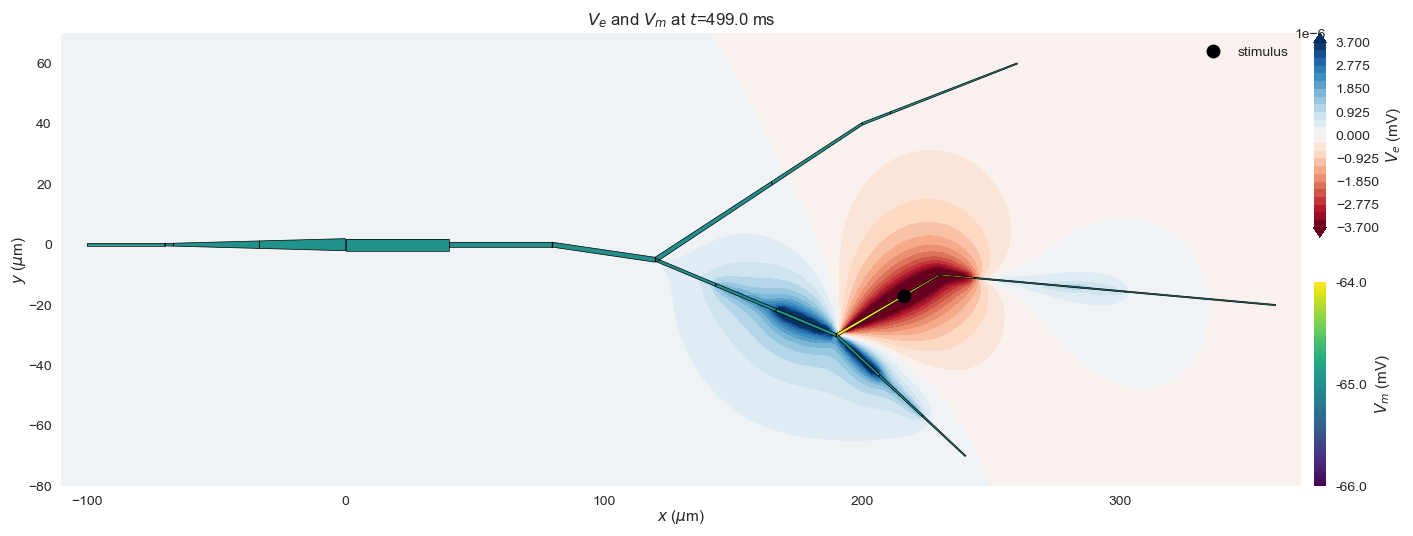

In [15]:
# show predictions at the last time point of simulation
time_index = -1

# use seaborn style
plt.style.use('seaborn')
plt.rcParams['image.cmap'] = 'viridis'

# create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=100)

# plot contours of V_e
lim = float(f'{abs(V_e).max() / 3:.1e}')
levels = np.linspace(-lim, lim, 25)
im_V_e = ax.contourf(X, Y, V_e[:, time_index].reshape(X.shape),
                     cmap='RdBu',
                     levels=levels,
                     extend='both')

# V_e colorbar:
cb = colorbar(fig, ax, im_V_e, height=0.45, voffset=0.55)
cb.set_label('$V_e$ (mV)')

# add outline of each CV with color coding according to membrane voltage
vlims = [-66., -64.]
polycol = get_cv_polycollection(cell_geometry, V_m[time_index, :], vlims=vlims)
im_V_m = ax.add_collection(polycol)

# V_m colorbar
cb2 = colorbar(fig, ax, im_V_m, height=0.45)
cb2.set_ticks([0, 0.5, 1])
cb2.set_ticklabels([vlims[0], np.mean(vlims), vlims[1]])
cb2.set_label(r'$V_m$ (mV)')

# draw segment outlines
ax.add_collection(get_segment_outlines(cell_geometry))

# add marker denoting clamp location
point = p.at(clamp_location)
ax.plot(point.x, point.y, 'ko', ms=10, label='stimulus')

ax.legend()

# axis annotations
ax.axis(axis)
ax.set_xlabel(r'$x$ ($\mu$m)', labelpad=0)
ax.set_ylabel(r'$y$ ($\mu$m)', labelpad=0)
ax.set_title(f'$V_e$ and $V_m$ at $t$={time[time_index]} ms')

# save file
# fig.savefig('Example_Arbor_swc.svg', bbox_inches='tight')

## Notes on output:
The spatial discretization is here deliberately coarse with only 3 CVs
per branch.
Hence the branch receiving input about 1/6 of the way from its root
(from `decor.place('(location 4 0.16667)', iclamp, '"iclamp"')`) is treated
as 3 separate line sources with inhomogeneous current density per length
unit. This inhomogeneity is due to the fact that the total transmembrane
current per CV may distributed across multiple segments with varying surface
area. The transmembrane current is assumed to be constant per length unit
per segment.

The parameter `cvs_per_branch = 3` above can be changed above to affect the number of CVs per branch.